In [1]:
from google.colab import drive
drive.mount('/content/gdrive/', force_remount=True)

Mounted at /content/gdrive/


In [2]:
import csv
import numpy as np
import json
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt

from cv2 import imread , cvtColor, COLOR_BGR2RGB, resize, findContours, boundingRect,RETR_EXTERNAL, CHAIN_APPROX_SIMPLE, COLOR_BGR2GRAY
import torchvision.transforms as transforms
from torch import from_numpy
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from keras.applications.vgg16 import preprocess_input
import matplotlib.patches as patches
from itertools import combinations

In [3]:
!pip install keras-tuner --upgrade

# chargement des données:

In [3]:
def lecture_fichier(nom_fichier):
  with open(nom_fichier, mode='r', encoding='utf-8') as fichier:
      lecteur_csv = csv.reader(fichier)
      data = np.array([ligne  for ligne in lecteur_csv ])[1:,:]

      ind=np.where(( data[:, 3] == 'Above') |  ( data[:, 3] == 'Left') |( data[:, 3] == 'Right')  | ( data[:, 3] == 'Under')  )[0]
      obj1 = data[:, 0][ind]
      obj2 = data[:, 1][ind]
      nb = data[:, 2][ind]
      noms_images = ['img-'+obj1[i]+'-'+ obj2[i]+'-'+nb[i]+'.png' for i in range(len(nb))]

      return noms_images, data[:, 3][ind]






In [4]:
def lecture_images_4C(path,noms_images, les_label):
    images_rgb = np.array([   cvtColor( resize(imread(path+noms_images[i]), (224,224)) ,  COLOR_BGR2RGB)
     for i in range(len(noms_images))])
    label_encoder = LabelEncoder()
    integer_encoded =  label_encoder.fit_transform(les_label)
    return images_rgb,  integer_encoded



In [5]:
def aire_bbox(x1, y1, x2, y2):
    # Calcule l'aire d'une bbox à partir de ses coordonnées
    largeur = abs(x2 - x1)
    hauteur = abs(y2 - y1)
    return largeur * hauteur

def bbox_plus_petite(bbox1, bbox2):
    # Calcule l'aire des deux bbox
    aire_bbox1 = aire_bbox(*bbox1)
    aire_bbox2 = aire_bbox(*bbox2)

    # Renvoie la bbox avec la plus petite aire
    if aire_bbox1 < aire_bbox2:
        return bbox1
    else:
        return bbox2

In [6]:
def do_bboxes_overlap(bbox1, bbox2):

    x1_1, y1_1, x2_1, y2_1 = bbox1
    x1_2, y1_2, x2_2, y2_2 = bbox2

    # Vérifier si les boîtes se chevauchent sur l'axe X
    overlap_x = x1_1 < x2_2 and x2_1 > x1_2

    # Vérifier si les boîtes se chevauchent sur l'axe Y
    overlap_y = y1_1 < y2_2 and y2_1 > y1_2

    # Si les boîtes se chevauchent sur les deux axes, elles partagent une région
    return overlap_x and overlap_y

In [7]:
def Bbox(ims, labels):


  #bounding_boxes = np.zeros((len(ims),2,2,2), dtype = np.int32)
  bounding_boxes = np.zeros((len(ims),16), dtype = np.int32)

  for i in range(len(ims)):


    image_gris = cvtColor(ims[i], COLOR_BGR2GRAY)
    image_gris[image_gris == image_gris[0][0]] = 0
    mask_obj1 = np.where(image_gris== np.unique(image_gris)[1], 255, 0).astype('uint8')
    mask_obj2 = np.where(image_gris== np.unique(image_gris)[2], 255, 0).astype('uint8')
    contours1, _ = findContours(mask_obj1, RETR_EXTERNAL, CHAIN_APPROX_SIMPLE)
    contours2, _ = findContours(mask_obj2, RETR_EXTERNAL, CHAIN_APPROX_SIMPLE)
    c = [contours1, contours2]




    for k in range(len(c)):
      contours = c[k]
      bounding_boxes_ima = []
      for e in range(len(contours)):
        x, y, w, h = boundingRect(contours[e])

        bounding_boxes_ima.append([x, y, x + w, y + h])


      if len(bounding_boxes_ima) ==2:
        comb= list(combinations(bounding_boxes_ima, 2))
        indx = [do_bboxes_overlap(comb[j][0], comb[j][1]) for j in range(len(comb))].index(True)

        bbox_p = bbox_plus_petite(comb[indx][0],comb[indx][1])

        bounding_boxes_ima.remove( bbox_p )




        bounding_boxes[i,k*8:(k+1)*8] = np.array( [  bounding_boxes_ima[0][1],bounding_boxes_ima[0][0],
                                          bounding_boxes_ima[0][1], bounding_boxes_ima[0][2],

                                          bounding_boxes_ima[0][3],bounding_boxes_ima[0][2],
                                          bounding_boxes_ima[0][3],  bounding_boxes_ima[0][0]], dtype=np.int32)


      else:

        bounding_boxes[i,k*8:(k+1)*8] = np.array( [  bounding_boxes_ima[0][1],bounding_boxes_ima[0][0],
                                          bounding_boxes_ima[0][1], bounding_boxes_ima[0][2],

                                        bounding_boxes_ima[0][3], bounding_boxes_ima[0][2],
                                          bounding_boxes_ima[0][3] ,bounding_boxes_ima[0][0] ], dtype=np.int32)



  bounding_boxes1 = np.zeros((len(ims),16), dtype = np.int32)
  bounding_boxes1[:,[0, 1, 2,3,4,5,6,7]] = bounding_boxes[:,[8, 9, 10,11,12,13,14,15]]
  bounding_boxes1[:,[8, 9, 10,11,12,13,14,15]] = bounding_boxes[:,[0, 1, 2,3,4,5,6,7]]

  return bounding_boxes1, labels.astype('int32')



In [8]:
def Plot_image_bbox(image, labb, box):


      fig, ax = plt.subplots(figsize=(5,7))
      ax.imshow( image )
      ax.set_title(labb )
      rect1 = patches.Rectangle((box[0][0], box[0][1]), abs(box[0][0] -box[0][2]),
                      abs(box[0][1] - box[0][3]),   linewidth=1, edgecolor='r', facecolor='none')
      rect2 = patches.Rectangle((box[1][0], box[1][1]), abs(box[1][0] -box[1][2]),
                      abs(box[1][1] - box[1][3]),   linewidth=1, edgecolor='b', facecolor='none')

      ax.add_patch(rect1)
      ax.add_patch(rect2)
      plt.show()

In [9]:
def plot_score(modele, metic_train,metric_test,lab_plot_train, lab_plot_test, title, name_ylab, n_epoch):
  # plot de la courbe loss (perte):
  plt.plot(np.arange(0,n_epoch),modele.history[metic_train], 'y', label= lab_plot_train )
  plt.plot(np.arange(0,n_epoch),modele.history[metric_test], 'r', label= lab_plot_test )
  plt.title(title)
  plt.xlabel('epochs')
  plt.ylabel(name_ylab)
  plt.legend()
  plt.show()

# separation train, validation, test:

In [10]:
def split_data(x_data, y_data, size):
  # Diviser les données en ensembles d'entraînement et de test
  return train_test_split(x_data, y_data, test_size=0.2, random_state=42, stratify=y_data)

In [11]:
def Split_Images_bbox(images, bboxs, labels, size):
  return  train_test_split(images, bboxs, labels, test_size=size, random_state=42)

#Evaluation des modèles:

In [12]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
from matplotlib.colors import ListedColormap

In [13]:
# Plot matrice de confusion normalisé:
def Plot_matrice_confusion(y_true, y_pred, classes, title, cmap=plt.cm.Blues):
  # Calcule la matrice de confusion
  cm = confusion_matrix(y_true, y_pred)
  cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
  fig, ax = plt.subplots()
  im = ax.imshow(cm, interpolation='nearest', cmap=cmap, vmin=0, vmax=1)
  ax.figure.colorbar(im, ax=ax)
  # Affiche toutes les étiquettes
  ax.set(xticks=np.arange(cm.shape[1]),
          yticks=np.arange(cm.shape[0]),
          xticklabels=classes, yticklabels=classes,
          title=title,
          ylabel='Étiquette réelle',
          xlabel='Étiquette prédite')




# Recherche des hyperparametres du modèle:

In [32]:
from tensorflow.keras.callbacks import EarlyStopping
def search(parametre_lr, App_mod, x_train, y_train,x_val, y_val ):

    # Arrêt précoce pour éviter le surajustement
    stop_early = EarlyStopping(monitor='val_loss', patience=6)
    l_acc_val = []
    l_epochs = []
    for lr in parametre_lr:
      le_modele = App_mod
      le_modele.compile(
          optimizer=Adam(learning_rate=lr),
          loss='sparse_categorical_crossentropy',
          metrics=['sparse_categorical_accuracy'])
      history = le_modele.fit(x_train, y_train, epochs=50, batch_size=64,validation_data=(x_val, y_val), callbacks=[stop_early])
      l_epochs.append(len(history.history['sparse_categorical_accuracy']))
      l_acc_val.append( history.history['sparse_categorical_accuracy'][-1])

    return  l_epochs, l_acc_val


def plot_results(l_lr, n_epoch, l_acc):
    # Récupérer les résultats de chaque essai
    fig, ax = plt.subplots()
    sc = ax.scatter(n_epoch, l_lr, c=l_acc, cmap='viridis')
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Epochs Learning Rate')
    ax.set_yscale('log')
    plt.colorbar(sc, label='Accuracy')
    plt.show()

#modele de classification d'images:

In [15]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dropout
from tensorflow.keras.regularizers import l1, l2, l1_l2

In [16]:
def Modele(n_classe,fine_tune):
  # Chargement de VGGNet sans sa partie de classification
  base_model = VGG16(weights=None, include_top=False, input_shape=(224, 224, 3))
  #----    Raffinement du modèle pré-entraîné ---------:


  # Geler les couches du modèle pré-entraîné
  for layer in base_model.layers[:-fine_tune]:
      layer.trainable = False





  x = base_model.output # Vecteur des caractéristiques
  #print('dimension de sortie: ',base_model.output.shape)
  x = Flatten()(x)  # Convertit les caractéristiques 3D en vecteur 1D

  # Ajouter la première couche FC (FC-0)

  x = Dense(512, activation='relu', name='FC-0')(x)

  # Ajouter la deuxième couche FC (FC-1)
  x = Dense(256, activation='relu', name='FC-1')(x)


  # Ajouter la couche de sortie pour la classification
  #predictions = Dense(n_classe, activation='softmax', name='predictions')(x)  # pour les n classes:
  predictions = Dense(n_classe, activation='softmax', name='predictions')(x)  # pour les n classes:

  model = Model(inputs=base_model.input, outputs=predictions)
  return model

# MLP pour la classification des images en utilisant les boites anglobantes:

In [ ]:
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
from tensorflow.keras.layers import TimeDistributed, Flatten,BatchNormalization, Activation

In [ ]:
def MLP( n_classes):

  return Sequential([Dense(64,input_shape = (16,)),#8
                     Dense(32, activation='relu'),
                     Dense(16, activation='relu'),
                     Dense(n_classes, activation='softmax')])



# Modèle de combinaison des sortiesdes modèles (images + boites englobantes):

In [ ]:
from keras.layers import Input, Concatenate, Dense
from keras.models import Model

In [ ]:
def Combine_modeles(modele1, modele2,num_classes ):

  #sorties des deux modèles:
  output_model1 = modele1.output
  output_model2 = modele2.output

  # Concatenation des sorties des deux modèles:
  combined_features = Concatenate()([output_model1, output_model2])

  # Ajout de couche de classification :
  classification_layer = Dense(num_classes, activation='softmax', name = 'classification_layer')(combined_features)

  # creation + Compilation du modele:
  combined_model = Model(inputs=[modele1.input, modele2.input], outputs=classification_layer)
  combined_model.compile(optimizer=Adam(learning_rate=0.00001), loss='categorical_crossentropy',metrics=['accuracy'] )

  return combined_model

# Resultats:

In [17]:
Noms_images_4C1, label1= lecture_fichier('/content/gdrive/MyDrive/Colab Notebooks/projetM2/ProjetIma/données_seg/données/SimpleShapes1_8.csv')
Noms_images_4C2, label2= lecture_fichier('/content/gdrive/MyDrive/Colab Notebooks/projetM2/ProjetIma/données_seg/données/SimpleShapes2_8.csv')


In [ ]:
print(np.shape (label1), np.shape(label2))

(645,) (863,)


In [18]:
images_rgb_1,lab1= lecture_images_4C('/content/gdrive/MyDrive/Colab Notebooks/projetM2/ProjetIma/données_seg/données/SimpleShapes1/',Noms_images_4C1, label1)
images_rgb_2, lab2 = lecture_images_4C('/content/gdrive/MyDrive/Colab Notebooks/projetM2/ProjetIma/données_seg/données/SimpleShapes2/',Noms_images_4C2, label2)
Images =  np.concatenate((images_rgb_1, images_rgb_2 ), axis=0)
Labels =  np.concatenate((lab1,lab2 ), axis=0)


In [19]:
nom_im =  np.concatenate((Noms_images_4C1,Noms_images_4C2 ), axis=0)


In [ ]:
print(np.shape(Images), np.shape(Labels))
print(np.unique(Labels, return_counts = True))

(1508, 224, 224, 3) (1508,)
(array([0, 1, 2, 3]), array([395, 365, 365, 383]))


##Classification des images:

In [20]:
X_train_val,X_test,Y_train_val, Y_test = split_data(Images, Labels, 0.2)
X_train,X_val,Y_train, Y_val = split_data(X_train_val, Y_train_val, 0.3)

Epoch 1/50
16/16 [==============================] - 17s 758ms/step - loss: 21.8527 - sparse_categorical_accuracy: 0.2552 - val_loss: 1.2983 - val_sparse_categorical_accuracy: 0.4711
Epoch 2/50
16/16 [==============================] - 12s 732ms/step - loss: 0.9226 - sparse_categorical_accuracy: 0.6535 - val_loss: 0.7868 - val_sparse_categorical_accuracy: 0.6860
Epoch 3/50
16/16 [==============================] - 12s 733ms/step - loss: 0.7210 - sparse_categorical_accuracy: 0.7303 - val_loss: 0.5012 - val_sparse_categorical_accuracy: 0.8471
Epoch 4/50
16/16 [==============================] - 11s 702ms/step - loss: 1.2404 - sparse_categorical_accuracy: 0.6680 - val_loss: 0.9171 - val_sparse_categorical_accuracy: 0.7025
Epoch 5/50
16/16 [==============================] - 12s 735ms/step - loss: 0.8202 - sparse_categorical_accuracy: 0.6888 - val_loss: 0.8041 - val_sparse_categorical_accuracy: 0.7149
Epoch 6/50
16/16 [==============================] - 12s 735ms/step - loss: 0.8751 - sparse_cat

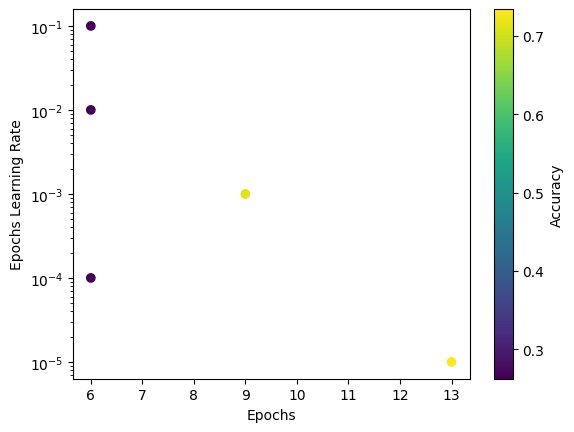

In [33]:
#le_modele= Modele(4, 0)

l_ep, l_acc = search([0.001,0.00001,0.1,0.01,0.0001], Modele(4, 0), X_train,Y_train, X_val,Y_val )
plot_results([0.001,0.00001,0.1,0.01,0.0001],l_ep, l_acc)

In [ ]:

Modele_classification_VGGNet_MLP = Modele(4, 0)
Modele_classification_VGGNet_MLP .compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['sparse_categorical_accuracy'])

In [ ]:
epochs = 30
dic_res = Modele_classification_VGGNet_MLP.fit(X_train, Y_train,
                epochs=epochs,batch_size=64,validation_data=(X_val, Y_val))

Epoch 1/30
16/16 [==============================] - 38s 2s/step - loss: 32.8226 - sparse_categorical_accuracy: 0.3205 - val_loss: 1.1564 - val_sparse_categorical_accuracy: 0.5496
Epoch 2/30
16/16 [==============================] - 13s 814ms/step - loss: 1.3560 - sparse_categorical_accuracy: 0.4336 - val_loss: 1.5865 - val_sparse_categorical_accuracy: 0.2603
Epoch 3/30
16/16 [==============================] - 12s 776ms/step - loss: 1.2293 - sparse_categorical_accuracy: 0.4938 - val_loss: 0.8594 - val_sparse_categorical_accuracy: 0.6901
Epoch 4/30
16/16 [==============================] - 12s 768ms/step - loss: 0.8808 - sparse_categorical_accuracy: 0.6763 - val_loss: 0.7663 - val_sparse_categorical_accuracy: 0.7066
Epoch 5/30
16/16 [==============================] - 13s 800ms/step - loss: 0.7703 - sparse_categorical_accuracy: 0.6992 - val_loss: 0.7648 - val_sparse_categorical_accuracy: 0.7190
Epoch 6/30
16/16 [==============================] - 13s 808ms/step - loss: 0.7318 - sparse_catego

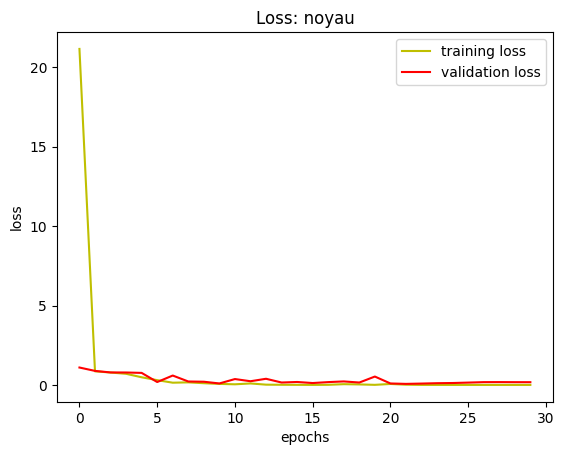

In [ ]:
plot_score(dic_res, 'loss','val_loss','training loss', 'validation loss', 'Loss: noyau', 'loss', 30)


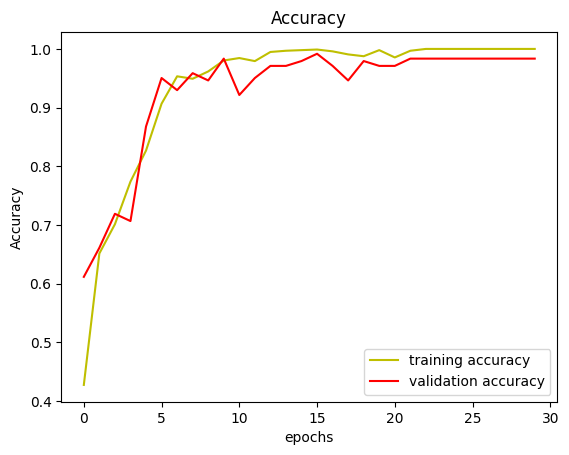

In [ ]:
plot_score(dic_res, 'sparse_categorical_accuracy','val_sparse_categorical_accuracy','training accuracy', 'validation accuracy', 'Accuracy', 'Accuracy', 30)


##Classification des coordonnées des boites englobantes:

In [ ]:
coord_bbox,liste_des_labels = Bbox(Images, Labels)
print(np.shape(coord_bbox))
#coord_box1p = coord_bbox[:,[0, 1, 4,5]]
#print(np.shape(coord_box1p))
print(liste_des_labels)

(1508, 16)
[0 2 0 ... 2 3 0]


[ 10   4  83   4  83  83  10  83  80 133 157 133 157 202  80 202]
[[62, 152, 139, 223], [27, 49, 63, 132]]


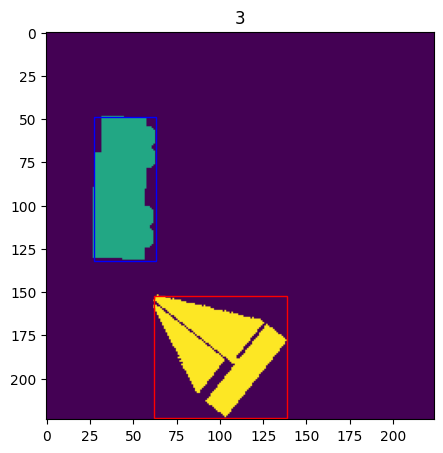

In [ ]:
n = 600
print(coord_bbox[0])
print([[coord_bbox[n][0],coord_bbox[n][1], coord_bbox[n][4], coord_bbox[n][5]],
                                       [coord_bbox[n][8],coord_bbox[n][9], coord_bbox[n][12], coord_bbox[n][13]]])
#Plot_image_bbox(Images[n], Labels[n],coord_bbox[n] )
Plot_image_bbox(Images[n], Labels[n],[[coord_bbox[n][0],coord_bbox[n][1], coord_bbox[n][4], coord_bbox[n][5]],
                                       [coord_bbox[n][8],coord_bbox[n][9], coord_bbox[n][12], coord_bbox[n][13]]] )



In [ ]:
Modelmlp = MLP(4)
#Modelmlp.compile(optimizer=Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy',
#metrics=['sparse_categorical_accuracy'] )

Modelmlp.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy',metrics=['accuracy'] )
Modelmlp.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_17 (Dense)            (None, 64)                1088      
                                                                 
 dense_18 (Dense)            (None, 32)                2080      
                                                                 
 dense_19 (Dense)            (None, 16)                528       
                                                                 
 dense_20 (Dense)            (None, 4)                 68        
                                                                 
Total params: 3764 (14.70 KB)
Trainable params: 3764 (14.70 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
#X_train_val,X_test,Y_train_val, Y_test = split_data(coord_bbox,to_categorical(liste_des_labels, num_classes=4), 0.2)
X_train_val,X_test,Y_train_val, Y_test = split_data(coord_bbox,to_categorical(liste_des_labels, num_classes=4), 0.2)
X_train,X_val,Y_train, Y_val = split_data(X_train_val, Y_train_val, 0.3)

In [ ]:
print(np.shape(X_train), np.shape(Y_train))
print(np.shape(X_val), np.shape(Y_val))
print(np.unique(Y_train, return_counts= True))

(964, 16) (964, 4)
(242, 16) (242, 4)
(array([0., 1.], dtype=float32), array([2892,  964]))


In [ ]:
epochs = 50

dic_res =Modelmlp.fit(X_train, Y_train, batch_size = 128, epochs=epochs,validation_data= (X_val, Y_val))

Epoch 1/50
8/8 [==============================] - 1s 29ms/step - loss: 52.1024 - accuracy: 0.2417 - val_loss: 47.8431 - val_accuracy: 0.2438
Epoch 2/50
8/8 [==============================] - 0s 10ms/step - loss: 43.8962 - accuracy: 0.2417 - val_loss: 40.3825 - val_accuracy: 0.2479
Epoch 3/50
8/8 [==============================] - 0s 7ms/step - loss: 36.5762 - accuracy: 0.2427 - val_loss: 33.4245 - val_accuracy: 0.2479
Epoch 4/50
8/8 [==============================] - 0s 7ms/step - loss: 29.7918 - accuracy: 0.2645 - val_loss: 26.8919 - val_accuracy: 0.2934
Epoch 5/50
8/8 [==============================] - 0s 8ms/step - loss: 23.6304 - accuracy: 0.2925 - val_loss: 21.2305 - val_accuracy: 0.3595
Epoch 6/50
8/8 [==============================] - 0s 10ms/step - loss: 18.0829 - accuracy: 0.3672 - val_loss: 16.1674 - val_accuracy: 0.4215
Epoch 7/50
8/8 [==============================] - 0s 7ms/step - loss: 13.2446 - accuracy: 0.4201 - val_loss: 11.7834 - val_accuracy: 0.4463
Epoch 8/50
8/8 [=

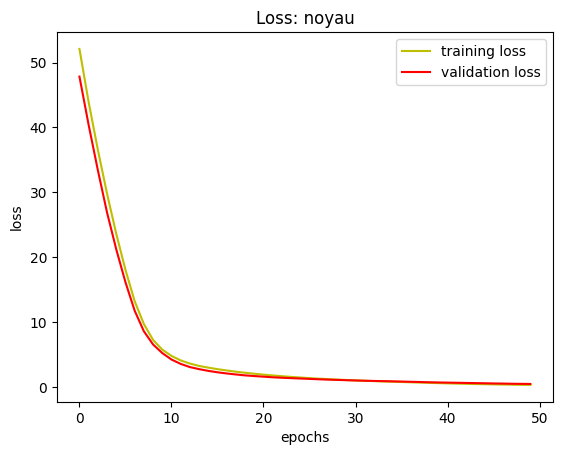

In [ ]:
plot_score(dic_res, 'loss','val_loss','training loss', 'validation loss', 'Loss: noyau', 'loss', 50)


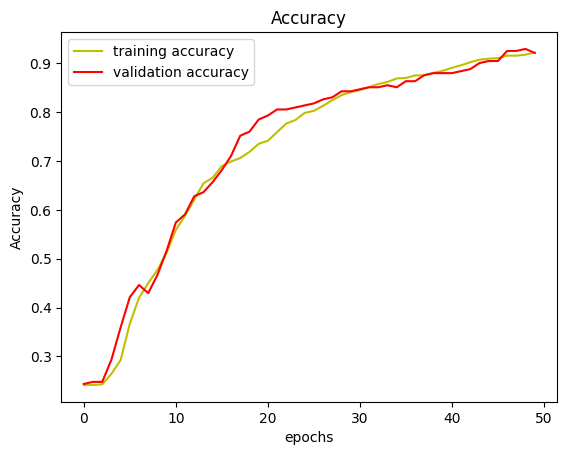

In [ ]:
plot_score(dic_res, 'accuracy','val_accuracy','training accuracy', 'validation accuracy', 'Accuracy', 'Accuracy', 50)


10/10 [==============================] - 0s 10ms/step


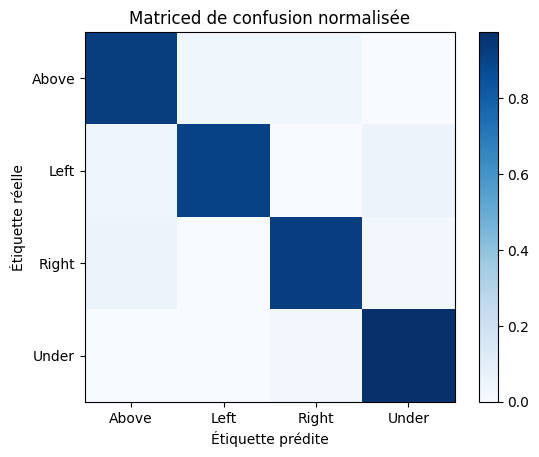

In [ ]:
noms_classes = ['Above','Left','Right','Under']
import tensorflow as tf

Plot_matrice_confusion(np.array([list(Y_test[i]).index(1) for i in range(len(Y_test))]), tf.argmax(Modelmlp.predict(X_test), axis=1), noms_classes,
                       'Matriced de confusion normalisée', cmap=plt.cm.Blues)

##Modele de conbinaison du modèle de classification des images et du modèle  de classification des boîtes englobantes.

In [ ]:
#------------------ Coordonnées des boites englobantes: ------------------
coord_bbox,liste_des_labels = Bbox(Images, Labels)
print(np.shape(coord_bbox), np.shape(Images))

(1508, 16) (1508, 224, 224, 3)


[  4  10   4  83  83  83  83  10 133  80 133 157 202 157 202  80]
[[63, 85, 122, 128], [132, 26, 187, 112]]


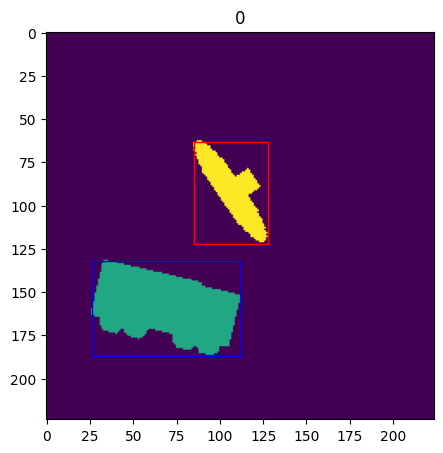

In [ ]:
n = 620
print(coord_bbox[0])
print([[coord_bbox[n][0],coord_bbox[n][1], coord_bbox[n][4], coord_bbox[n][5]],
                                       [coord_bbox[n][8],coord_bbox[n][9], coord_bbox[n][12], coord_bbox[n][13]]])
#Plot_image_bbox(Images[n], Labels[n],coord_bbox[n] )
Plot_image_bbox(Images[n], Labels[n],[[coord_bbox[n][1],coord_bbox[n][0], coord_bbox[n][5], coord_bbox[n][4]],
                                       [coord_bbox[n][9],coord_bbox[n][8], coord_bbox[n][13], coord_bbox[n][12]]] )


In [ ]:
images_train_v, images_test, bounding_boxes_train_v, bounding_boxes_test, labels_train_v, labels_test  = Split_Images_bbox(Images, coord_bbox, to_categorical(liste_des_labels, num_classes=4), 0.15)
images_train, images_val, bounding_boxes_train, bounding_boxes_val, labels_train, labels_val  = Split_Images_bbox(images_train_v, bounding_boxes_train_v,labels_train_v, 0.15)


In [ ]:
print(np.shape(images_train ),  np.shape(bounding_boxes_train), np.shape(labels_train))

(1088, 224, 224, 3) (1088, 16) (1088, 4)


In [ ]:
# Modèle pour la classification d’images segmentées:
Modele_classification_VGGNet_MLP = Modele(4, 0)
# Modèle pour la classification des boites englobante:
Modelmlp = MLP(4)

In [ ]:
Comb_modeles = Combine_modeles(Modele_classification_VGGNet_MLP, Modelmlp,4 )
Comb_modeles.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 block1_conv1 (Conv2D)       (None, 224, 224, 64)         1792      ['input_3[0][0]']             
                                                                                                  
 block1_conv2 (Conv2D)       (None, 224, 224, 64)         36928     ['block1_conv1[0][0]']        
                                                                                                  
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)         0         ['block1_conv2[0][0]']        
                                                                                            

In [ ]:

res_comb_modeles = Comb_modeles.fit([images_train,  bounding_boxes_train], labels_train,validation_data = ([images_val,  bounding_boxes_val], labels_val), epochs=150, batch_size=128)

Epoch 1/150
9/9 [==============================] - 120s 4s/step - loss: 1.4118 - accuracy: 0.2960 - val_loss: 1.3383 - val_accuracy: 0.3161
Epoch 2/150
9/9 [==============================] - 15s 2s/step - loss: 1.3270 - accuracy: 0.3401 - val_loss: 1.2931 - val_accuracy: 0.3938
Epoch 3/150
9/9 [==============================] - 16s 2s/step - loss: 1.2867 - accuracy: 0.4375 - val_loss: 1.2641 - val_accuracy: 0.4922
Epoch 4/150
9/9 [==============================] - 16s 2s/step - loss: 1.2460 - accuracy: 0.5175 - val_loss: 1.2216 - val_accuracy: 0.5389
Epoch 5/150
9/9 [==============================] - 15s 2s/step - loss: 1.2316 - accuracy: 0.5285 - val_loss: 1.2049 - val_accuracy: 0.5544
Epoch 6/150
9/9 [==============================] - 16s 2s/step - loss: 1.2211 - accuracy: 0.5441 - val_loss: 1.2082 - val_accuracy: 0.5389
Epoch 7/150
9/9 [==============================] - 16s 2s/step - loss: 1.2110 - accuracy: 0.5450 - val_loss: 1.1964 - val_accuracy: 0.5596
Epoch 8/150
9/9 [=========

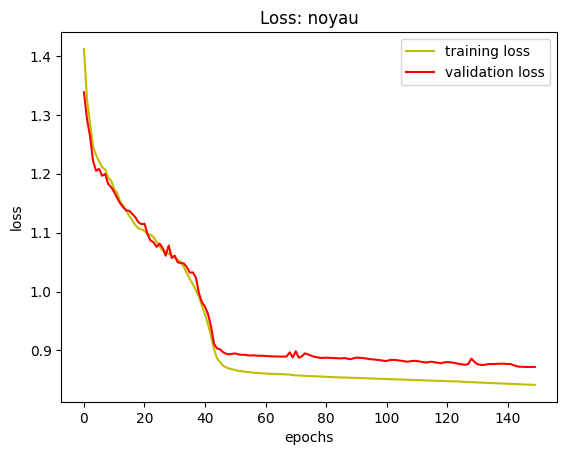

In [ ]:
plot_score(res_comb_modeles , 'loss','val_loss','training loss', 'validation loss', 'Loss: noyau', 'loss', 150)


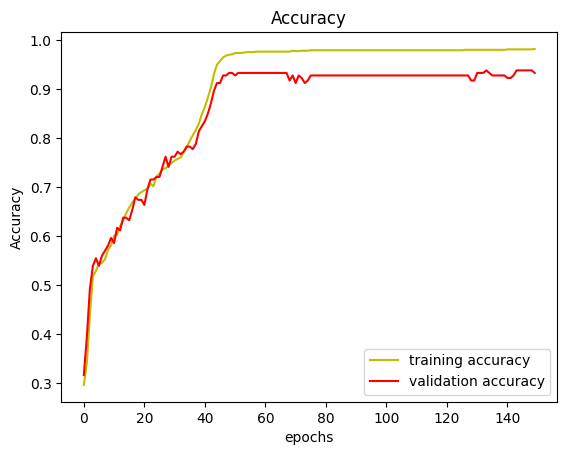

In [ ]:
plot_score(res_comb_modeles , 'accuracy','val_accuracy','training accuracy', 'validation accuracy', 'Accuracy', 'Accuracy', 150)


8/8 [==============================] - 1s 122ms/step


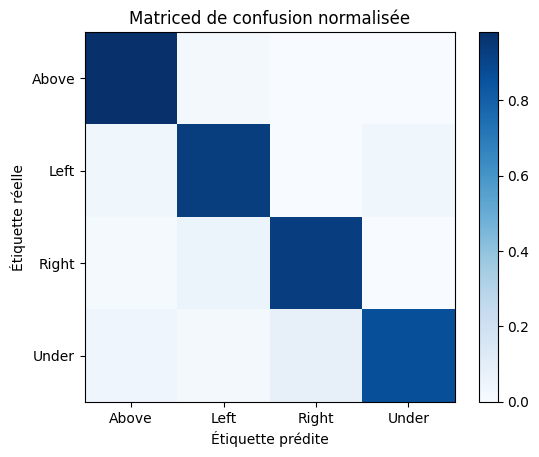

In [ ]:
noms_classes = ['Above','Left','Right','Under']
import tensorflow as tf

Plot_matrice_confusion(np.array([list(labels_test[i]).index(1) for i in range(len(labels_test))]), tf.argmax(Comb_modeles.predict([images_test,  bounding_boxes_test]), axis=1), noms_classes,
                       'Matriced de confusion normalisée', cmap=plt.cm.Blues)

In [ ]:
# Sauvegarde:
Comb_modeles.save_weights('/content/gdrive/MyDrive/Colab Notebooks/projetM2/ProjetIma/données_seg/parametres_modele/Comb_modele_poids.h5')

In [ ]:
# Sauvegarder l'architecture du modèle, les poids et la configuration d'entraînement
Comb_modeles.save('/content/gdrive/MyDrive/Colab Notebooks/projetM2/ProjetIma/données_seg/parametres_modele/Comb_modele_arch.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
